In [230]:
# Import all necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix, classification_report 
import subprocess
import joblib
import re 
import utils
# Get multiple outputs in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

##### Data Collection

In [231]:
customers = pd.read_csv("https://raw.githubusercontent.com/x4nth055/pythoncode-tutorials/master/machine-learning/customer-churn-detection/Churn_Modelling.csv")
print("Data read into dataframe!")

Data read into dataframe!


In [232]:
customers.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [233]:
customers.shape

(10000, 14)

In [234]:
geography = list(customers.columns.values)
print([match.group(0) for Geography in geography for match in[(re.compile(".*(Spain).*")).search(Geography)] if match])
print([match.group(0) for Geography in geography for match in[(re.compile(".*(France).*")).search(Geography)] if match])
print([match.group(0) for Geography in geography for match in[(re.compile(".*(Germany).*")).search(Geography)] if match])

[]
[]
[]


##### Data Understanding

In [ ]:
customers["Gender"].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [236]:
customers["Geography"].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [237]:
customers["Exited"].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [238]:
customers.duplicated().sum()

0

In [239]:
# sum each column
ing = customers.iloc[:, 1:].sum(axis=0)

In [240]:
# profile for HasCrCard
HasCrCard = customers.groupby("HasCrCard").mean()
HasCrCard.head()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited
HasCrCard,,,,,,,,,,
0,4997.824788,1.569250e+07,651.345331,39.112054,4.911715,77920.787552,1.527334,0.524278,100974.397711,0.208149
1,5001.616726,1.569029e+07,650.187952,38.842381,5.054996,75886.913330,1.531396,0.511269,99721.161949,0.201843


##### Univariate Plot of Numerical Training Sets

<AxesSubplot: ylabel='CreditScore'>

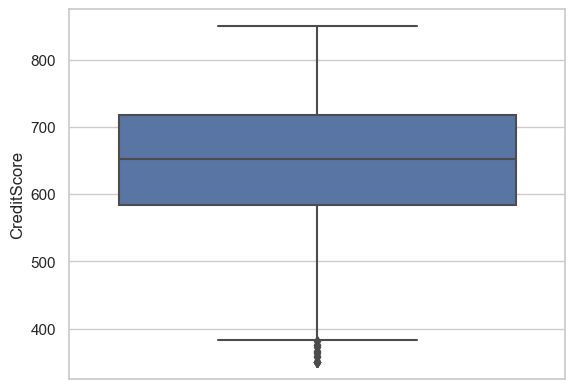

In [241]:
sns.set(style="whitegrid")
sns.boxplot(y=customers['CreditScore'])

<AxesSubplot: ylabel='Balance'>

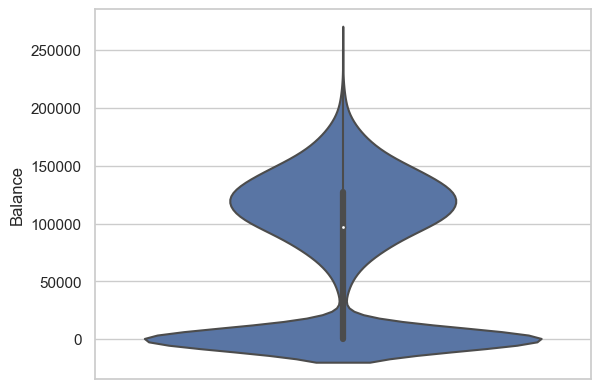

In [242]:
sns.violinplot(y = customers['Balance'])

<AxesSubplot: xlabel='NumOfProducts'>

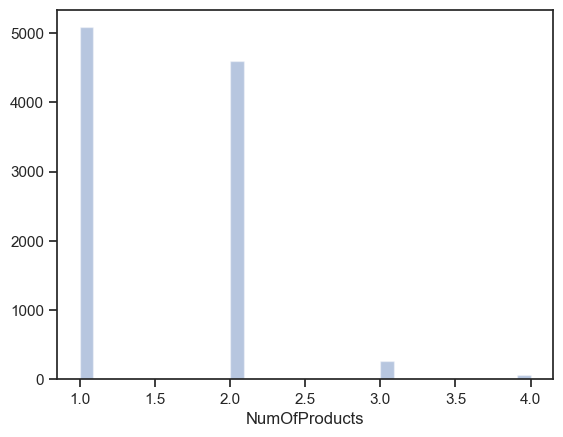

In [243]:
sns.set(style = 'ticks')
sns.distplot(customers.NumOfProducts, hist=True, kde=False)

<AxesSubplot: xlabel='EstimatedSalary', ylabel='Density'>

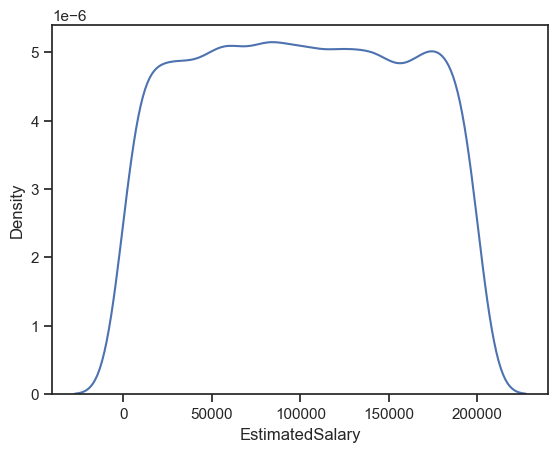

In [244]:
# When dealing with numerical characteristics, one of the most useful statistics to examine is the data distribution.
# we can use Kernel-Density-Estimation plot for that purpose. 
sns.kdeplot(customers.EstimatedSalary)

##### Data Preparation

In [245]:
# Separating out different columns into various categories as defined above
target_var = ['Exited']
cols_to_remove = ['RowNumber', 'CustomerId']
# numerical columns
num_feats = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
# categorical columns
cat_feats = ['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

In [246]:
y = customers[target_var].values
customers.drop(cols_to_remove, axis=1, inplace=True)

In [247]:
# Keeping aside a test/holdout set
customers_train_val, customers_test, y_train_val, y_test = train_test_split(customers, y.ravel(), test_size = 0.1, random_state = 42)

# Splitting into train and validation set
customers_train, customers_val, y_train, y_val = train_test_split(customers_train_val, y_train_val, test_size = 0.12, random_state = 42)
customers_train.shape, customers_val.shape, customers_test.shape, y_train.shape, y_val.shape, y_test.shape
np.mean(y_train), np.mean(y_val), np.mean(y_test)

((7920, 12), (1080, 12), (1000, 12), (7920,), (1080,), (1000,))

(0.20303030303030303, 0.22037037037037038, 0.191)

##### Label Encoding for Gender column

In [248]:
# label encoding With  the sklearn method
le = LabelEncoder()
# Label encoding of Gender variable
customers_train['Gender'] = le.fit_transform(customers_train['Gender'])
le_gender_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_gender_mapping

{'Female': 0, 'Male': 1}

In [249]:
# Encoding Gender feature for validation and test set
customers_val['Gender'] = customers_val.Gender.map(le_gender_mapping)
customers_test['Gender'] = customers_test.Gender.map(le_gender_mapping)

# Filling missing/NaN values created due to new categorical levels
customers_val['Gender'].fillna(-1, inplace=True)
customers_test['Gender'].fillna(-1, inplace=True)

##### One-Hot Encoding for Geography column

In [250]:
# With the sklearn method(LabelEncoder())
le_ohe = LabelEncoder()
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse=False)
enc_train = le_ohe.fit_transform(customers_train.Geography).reshape(customers_train.shape[0],1)
ohe_train = ohe.fit_transform(enc_train)
ohe_train

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [251]:
# mapping between classes
le_ohe_geography_mapping = dict(zip(le_ohe.classes_, le_ohe.transform(le_ohe.classes_)))
le_ohe_geography_mapping

{'France': 0, 'Germany': 1, 'Spain': 2}

In [252]:
# Encoding Geography feature for validation and test set
enc_val = customers_val.Geography.map(le_ohe_geography_mapping).ravel().reshape(-1,1)
enc_test = customers_test.Geography.map(le_ohe_geography_mapping).ravel().reshape(-1,1)

# Filling missing/NaN values created due to new categorical levels
enc_val[np.isnan(enc_val)] = 9999
enc_test[np.isnan(enc_test)] = 9999

In [253]:
ohe_val = ohe.transform(enc_val)
ohe_test = ohe.transform(enc_test)

In [254]:
# Show what happens when a new value is inputted into the OHE 
ohe.transform(np.array([[9999]]))

array([[0., 0., 0.]])

In [255]:
# Adding one-hot encoded column to the data frame and removing the original feature
cols = ['country_' + str(x) for x in le_ohe_geography_mapping.keys()]
cols

['country_France', 'country_Germany', 'country_Spain']

In [256]:
# Adding to the respective dataframes
customers_train = pd.concat([customers_train.reset_index(), pd.DataFrame(ohe_train, columns = cols)], axis = 1).drop(['index'], axis=1)
customers_val = pd.concat([customers_val.reset_index(), pd.DataFrame(ohe_val, columns = cols)], axis = 1).drop(['index'], axis=1)
customers_test = pd.concat([customers_test.reset_index(), pd.DataFrame(ohe_test, columns = cols)], axis = 1).drop(['index'], axis=1)
print("Training set")
customers_train.head()
print("\n\nValidation set")
customers_val.head()
print("\n\nTest set")
customers_test.head()

Training set


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Yermakova,678,Germany,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0
1,Warlow-Davies,613,France,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0
2,Fu,628,France,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0
3,Shih,513,France,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0
4,Mahmood,639,France,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0




Validation set


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Sun,757,France,1,36,7,144852.06,1,0,0,130861.95,0,1.0,0.0,0.0
1,Russo,552,France,1,29,10,0.00,2,1,0,12186.83,0,1.0,0.0,0.0
2,Munro,619,France,0,30,7,70729.17,1,1,1,160948.87,0,1.0,0.0,0.0
3,Perkins,633,France,1,35,10,0.00,2,1,0,65675.47,0,1.0,0.0,0.0
4,Aliyeva,698,Spain,1,38,10,95010.92,1,1,1,105227.86,0,0.0,0.0,1.0




Test set


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Anderson,596,Germany,1,32,3,96709.07,2,0,0,41788.37,0,0.0,1.0,0.0
1,Herring,623,France,1,43,1,0.00,2,1,1,146379.30,0,1.0,0.0,0.0
2,Amechi,601,Spain,0,44,4,0.00,2,1,0,58561.31,0,0.0,0.0,1.0
3,Liang,506,Germany,1,59,8,119152.10,2,1,1,170679.74,0,0.0,1.0,0.0
4,Chuang,560,Spain,0,27,7,124995.98,1,1,1,114669.79,0,0.0,0.0,1.0


In [257]:
# Dropping the original Geography Column
customers_train.drop(['Geography'], axis=1, inplace=True)
customers_val.drop(['Geography'], axis=1, inplace=True)
customers_test.drop(['Geography'], axis=1, inplace=True)

##### Target Encoding for Surname Column

In [258]:
means = customers_train.groupby(['Surname']).Exited.mean()
means.head()
means.tail()

Surname
Abazu       0.00
Abbie       0.00
Abbott      0.25
Abdullah    1.00
Abdulov     0.00
Name: Exited, dtype: float64

Surname
Zubarev     0.0
Zubareva    0.0
Zuev        0.0
Zuyev       0.0
Zuyeva      0.0
Name: Exited, dtype: float64

In [259]:
global_mean = y_train.mean()
global_mean

0.20303030303030303

In [260]:
# Creating new encoded features for surname - Target (mean) encoding
customers_train['Surname_mean_churn'] = customers_train.Surname.map(means)
customers_train['Surname_mean_churn'].fillna(global_mean, inplace=True)

In [261]:
# Calculating the frequency of each Surname
freqs = customers_train.groupby(['Surname']).size()
freqs.head()

Surname
Abazu       2
Abbie       1
Abbott      4
Abdullah    1
Abdulov     1
dtype: int64

In [262]:
#Create frequency encoding - Number of instances of each category in the data
customers_train['Surname_freq'] = customers_train.Surname.map(freqs)
customers_train['Surname_freq'].fillna(0, inplace=True)

In [263]:
# Creating Leave-one-out target encoding for Surname
customers_train['Surname_enc'] = ((customers_train.Surname_freq * customers_train.Surname_mean_churn) - customers_train.Exited)/(customers_train.Surname_freq - 1)
# Fill NaNs occuring due to category frequency being 1 or less
customers_train['Surname_enc'].fillna((((customers_train.shape[0] * global_mean) - customers_train.Exited) / (customers_train.shape[0] - 1)), inplace=True)
customers_train.head(5)

,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_mean_churn,Surname_freq,Surname_enc
0,Yermakova,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0,0.000000,4,0.000000
1,Warlow-Davies,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0,0.000000,2,0.000000
2,Fu,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0,0.200000,10,0.222222
3,Shih,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0,0.285714,21,0.300000
4,Mahmood,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0,0.333333,3,0.500000


In [264]:
# Replacing by category means and new category levels by global mean
customers_val['Surname_enc'] = customers_val.Surname.map(means)
customers_val['Surname_enc'].fillna(global_mean, inplace=True)
customers_test['Surname_enc'] = customers_test.Surname.map(means)
customers_test['Surname_enc'].fillna(global_mean, inplace=True)
# Show that using LOO Target encoding decorrelates features
customers_train[['Surname_mean_churn', 'Surname_enc', 'Exited']].corr()

,Surname_mean_churn,Surname_enc,Exited
Surname_mean_churn,1.000000,0.54823,0.562677
Surname_enc,0.548230,1.00000,-0.026440
Exited,0.562677,-0.02644,1.000000


In [265]:
# Deleting the Surname and other redundant columns across the three datasets:
customers_train.drop(['Surname_mean_churn'], axis=1, inplace=True)
customers_train.drop(['Surname_freq'], axis=1, inplace=True)
customers_train.drop(['Surname'], axis=1, inplace=True)
customers_val.drop(['Surname'], axis=1, inplace=True)
customers_test.drop(['Surname'], axis=1, inplace=True)
customers_train.head()


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc
0,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0,0.000000
1,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0,0.000000
2,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0,0.222222
3,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0,0.300000
4,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0,0.500000


In [266]:
# Check the linear correlation (rho) between individual features and the target variable:
corr = customers_train.corr()


In [267]:
# Check association of categorical features with the target variable:
cat_vars_bv = ['Gender', 'IsActiveMember', 'country_Germany', 'country_France']

for col in cat_vars_bv:
    customers_train.groupby([col]).Exited.mean()
    print()


Gender
0    0.248191
1    0.165511
Name: Exited, dtype: float64

IsActiveMember
0    0.266285
1    0.143557
Name: Exited, dtype: float64

country_Germany
0.0    0.163091
1.0    0.324974
Name: Exited, dtype: float64

country_France
0.0    0.245877
1.0    0.160593
Name: Exited, dtype: float64

In [268]:
# Computed mean on churned or non chuned custmers group by number of product on training data
col = 'NumOfProducts'
customers_train.groupby([col]).Exited.mean()
# unique "NumOfProducts" on training data
customers_train[col].value_counts()

NumOfProducts
1    0.273428
2    0.076881
3    0.825112
4    1.000000
Name: Exited, dtype: float64

1    4023
2    3629
3     223
4      45
Name: NumOfProducts, dtype: int64

In [269]:
eps = 1e-6

customers_train['bal_per_product'] = customers_train.Balance/(customers_train.NumOfProducts + eps)
customers_train['bal_by_est_salary'] = customers_train.Balance/(customers_train.EstimatedSalary + eps)
customers_train['tenure_age_ratio'] = customers_train.Tenure/(customers_train.Age + eps)
customers_train['age_surname_mean_churn'] = np.sqrt(customers_train.Age) * customers_train.Surname_enc

In [270]:
new_cols = ['bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio', 'age_surname_mean_churn']
# Ensuring that the new column doesn't have any missing values
customers_train[new_cols].isnull().sum()

bal_per_product           0
bal_by_est_salary         0
tenure_age_ratio          0
age_surname_mean_churn    0
dtype: int64

<AxesSubplot: >

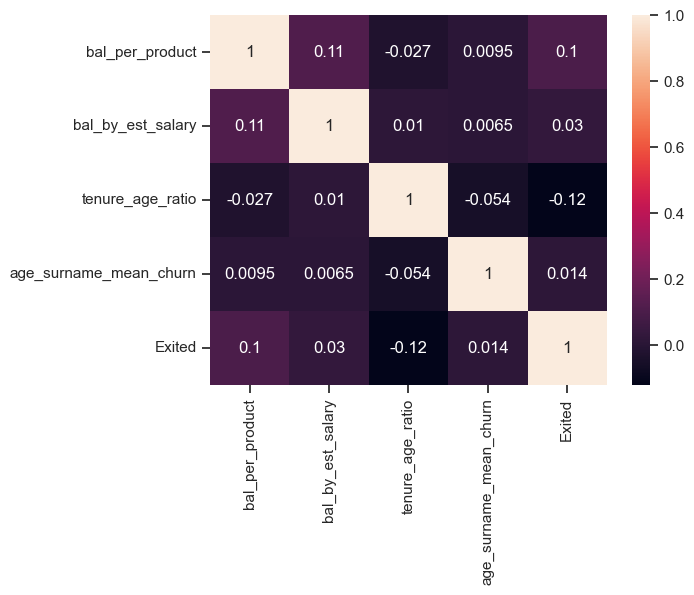

In [271]:
# Linear association of new columns with target variables to judge importance
sns.heatmap(customers_train[new_cols + ['Exited']].corr(), annot=True)

In [272]:
customers_val['bal_per_product'] = customers_val.Balance/(customers_val.NumOfProducts + eps)
customers_val['bal_by_est_salary'] = customers_val.Balance/(customers_val.EstimatedSalary + eps)
customers_val['tenure_age_ratio'] = customers_val.Tenure/(customers_val.Age + eps)
customers_val['age_surname_mean_churn'] = np.sqrt(customers_val.Age) * customers_val.Surname_enc
customers_test['bal_per_product'] = customers_test.Balance/(customers_test.NumOfProducts + eps)
customers_test['bal_by_est_salary'] = customers_test.Balance/(customers_test.EstimatedSalary + eps)
customers_test['tenure_age_ratio'] = customers_test.Tenure/(customers_test.Age + eps)
customers_test['age_surname_mean_churn'] = np.sqrt(customers_test.Age) * customers_test.Surname_enc

In [273]:
# initialize the standard scaler
sc = StandardScaler()
cont_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Surname_enc', 'bal_per_product'
             , 'bal_by_est_salary', 'tenure_age_ratio', 'age_surname_mean_churn']
cat_vars = ['Gender', 'HasCrCard', 'IsActiveMember', 'country_France', 'country_Germany', 'country_Spain']
# Scaling only continuous columns
cols_to_scale = cont_vars
sc_X_train = sc.fit_transform(customers_train[cols_to_scale])
# Converting from array to dataframe and naming the respective features/columns
sc_X_train = pd.DataFrame(data=sc_X_train, columns=cols_to_scale)
sc_X_train.shape
sc_X_train.head()

(7920, 11)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn
0,0.284761,-0.274383,-1.389130,0.670778,0.804059,-1.254732,-1.079210,-0.062389,0.095448,-1.232035,-1.062507
1,-0.389351,-1.128482,-0.004763,0.787860,-0.912423,1.731950,-1.079210,1.104840,-0.118834,0.525547,-1.062507
2,-0.233786,0.579716,1.379604,-1.218873,0.804059,-0.048751,0.094549,-1.100925,-0.155854,0.690966,0.193191
3,-1.426446,-0.843782,-0.004763,-1.218873,0.804059,1.094838,0.505364,-1.100925,-0.155854,0.318773,0.321611
4,-0.119706,-1.602981,-0.350855,-1.218873,0.804059,-1.244806,1.561746,-1.100925,-0.155854,0.487952,0.912973


In [274]:
# Scaling validation and test sets by transforming the mapping obtained through the training set
sc_X_val = sc.transform(customers_val[cols_to_scale])
sc_X_test = sc.transform(customers_test[cols_to_scale])
# Converting val and test arrays to dataframes for re-usability
sc_X_val = pd.DataFrame(data=sc_X_val, columns=cols_to_scale)
sc_X_test = pd.DataFrame(data=sc_X_test, columns=cols_to_scale)

##### Feature Selection Using RFE

In [275]:
# Creating feature-set and target for RFE model
y = customers_train['Exited'].values
X = customers_train[cat_vars + cont_vars]
X.columns = cat_vars + cont_vars
X.columns

Index(['Gender', 'HasCrCard', 'IsActiveMember', 'country_France',
       'country_Germany', 'country_Spain', 'CreditScore', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'EstimatedSalary', 'Surname_enc',
       'bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio',
       'age_surname_mean_churn'],
      dtype='object')

##### Data Modelling

In [276]:
# for logistics regression
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=10) 
rfe = rfe.fit(X.values, y) 
# mask of selected features
print(rfe.support_)
# The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature 
print(rfe.ranking_)

[ True  True  True  True  True  True False  True False False  True False
  True False False  True False]
[1 1 1 1 1 1 4 1 3 6 1 8 1 7 5 1 2]


In [277]:
mask = rfe.support_.tolist()
selected_feats = [b for a,b in zip(mask, X.columns) if a]
selected_feats

['Gender',
 'HasCrCard',
 'IsActiveMember',
 'country_France',
 'country_Germany',
 'country_Spain',
 'Age',
 'NumOfProducts',
 'Surname_enc',
 'tenure_age_ratio']

In [278]:
# For Decision Tree
rfe_dt = RFE(estimator=DecisionTreeClassifier(max_depth = 4, criterion = 'entropy'), n_features_to_select=10) 
rfe_dt = rfe_dt.fit(X.values, y)  

In [279]:
mask = rfe_dt.support_.tolist()
selected_feats_dt = [b for a,b in zip(mask, X.columns) if a]
selected_feats_dt

['IsActiveMember',
 'country_Germany',
 'Age',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'bal_per_product',
 'bal_by_est_salary',
 'tenure_age_ratio',
 'age_surname_mean_churn']

In [280]:
# Train models on features selected with RFE
selected_cat_vars = [x for x in selected_feats if x in cat_vars]
selected_cont_vars = [x for x in selected_feats if x in cont_vars]
# Using categorical features and scaled numerical features
X_train = np.concatenate((customers_train[selected_cat_vars].values, sc_X_train[selected_cont_vars].values), axis=1)
X_val = np.concatenate((customers_val[selected_cat_vars].values, sc_X_val[selected_cont_vars].values), axis=1)
X_test = np.concatenate((customers_test[selected_cat_vars].values, sc_X_test[selected_cont_vars].values), axis=1)
# print the shapes
X_train.shape, X_val.shape, X_test.shape

((7920, 10), (1080, 10), (1000, 10))

In [281]:
# Obtaining class weights based on the class samples imbalance ratio
_, num_samples = np.unique(y_train, return_counts=True)
weights = np.max(num_samples)/num_samples
# Define weight dictionnary
weights_dict = dict()
class_labels = [0,1]
# Weights associated with classes
for a,b in zip(class_labels,weights):
    weights_dict[a] = b

weights_dict

{0: 1.0, 1: 3.925373134328358}

In [282]:
# Re-defining X_train and X_val to consider original unscaled continuous features. y_train and y_val remain unaffected
X_train = customers_train[selected_feats_dt].values
X_val = customers_val[selected_feats_dt].values
# Decision tree classiier model
clf = DecisionTreeClassifier(criterion='entropy', class_weight=weights_dict, max_depth=4, max_features=None
                            , min_samples_split=25, min_samples_leaf=15)
# Fit the model
clf.fit(X_train, y_train)
# Checking the importance of different features of the model
pd.DataFrame({'features': selected_feats,
              'importance': clf.feature_importances_
             }).sort_values(by='importance', ascending=False)

DecisionTreeClassifier(class_weight={0: 1.0, 1: 3.925373134328358},
                       criterion='entropy', max_depth=4, min_samples_leaf=15,
                       min_samples_split=25)

,features,importance
2,IsActiveMember,0.476841
4,country_Germany,0.351863
0,Gender,0.096402
7,NumOfProducts,0.042667
1,HasCrCard,0.028361
5,country_Spain,0.003865
3,country_France,0.000000
6,Age,0.000000
8,Surname_enc,0.000000
9,tenure_age_ratio,0.000000


In [283]:
# Validation metrics
print(f'Confusion Matrix: {confusion_matrix(y_val, clf.predict(X_val))}')
print(f'Area Under Curve: {roc_auc_score(y_val, clf.predict(X_val))}')
print(f'Recall score: {recall_score(y_val,clf.predict(X_val))}')
print(f'Classification report: \n{classification_report(y_val,clf.predict(X_val))}')

Confusion Matrix: [[633 209]
 [ 61 177]]
Area Under Curve: 0.7477394758378411
Recall score: 0.7436974789915967
Classification report: 
              precision    recall  f1-score   support

           0       0.91      0.75      0.82       842
           1       0.46      0.74      0.57       238

    accuracy                           0.75      1080
   macro avg       0.69      0.75      0.70      1080
weighted avg       0.81      0.75      0.77      1080



In [284]:
# Decision tree Classifier
clf = DecisionTreeClassifier(criterion='entropy', class_weight=weights_dict, 
                            max_depth=3, max_features=None,
                            min_samples_split=25, min_samples_leaf=15)
# We fit the model
clf.fit(X_train, y_train)
# Export now as a dot file
dot_data = export_graphviz(clf, out_file='tree.dot',
                          feature_names=selected_feats_dt,
                          class_names=['Did not churn', 'Churned'],
                          rounded=True, proportion=False,
                          precision=2, filled=True)
# Convert to png using system command (requires Graphviz)
subprocess.run(['dot', '-Tpng','tree.dot', '-o', 'tree.png', '-Gdpi=600'])
# Display the rule-set of a single tree
from IPython.display import Image
Image(filename='tree.png')

DecisionTreeClassifier(class_weight={0: 1.0, 1: 3.925373134328358},
                       criterion='entropy', max_depth=3, min_samples_leaf=15,
                       min_samples_split=25)

FileNotFoundError: [WinError 2] The system cannot find the file specified

In [ ]:
# Model run through pipelines 
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """ 
    Encodes categorical columns using LabelEncoding, OneHotEncoding and TargetEncoding.
    LabelEncoding is used for binary categorical columns
    OneHotEncoding is used for columns with <= 10 distinct values
    TargetEncoding is used for columns with higher cardinality (>10 distinct values)
    
    """

    def __init__(self, cols = None, lcols = None, ohecols = None, tcols = None, reduce_df = False):
        """
        
        Parameters
        ----------
        cols : list of str
            Columns to encode.  Default is to one-hot/target/label encode all categorical columns in the DataFrame.
        reduce_df : bool
            Whether to use reduced degrees of freedom for encoding
            (that is, add N-1 one-hot columns for a column with N 
            categories). E.g. for a column with categories A, B, 
            and C: When reduce_df is True, A=[1, 0], B=[0, 1],
            and C=[0, 0].  When reduce_df is False, A=[1, 0, 0], 
            B=[0, 1, 0], and C=[0, 0, 1]
            Default = False
        
        """
        
        if isinstance(cols,str):
            self.cols = [cols]
        else :
            self.cols = cols
        
        if isinstance(lcols,str):
            self.lcols = [lcols]
        else :
            self.lcols = lcols
        
        if isinstance(ohecols,str):
            self.ohecols = [ohecols]
        else :
            self.ohecols = ohecols
        
        if isinstance(tcols,str):
            self.tcols = [tcols]
        else :
            self.tcols = tcols
        
        self.reduce_df = reduce_df
    
    
    def fit(self, X, y):
        """Fit label/one-hot/target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [c for c in X if str(X[c].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')
        
        # Separating out lcols, ohecols and tcols
        if self.lcols is None:
            self.lcols = [c for c in self.cols if X[c].nunique() <= 2]
        
        if self.ohecols is None:
            self.ohecols = [c for c in self.cols if ((X[c].nunique() > 2) & (X[c].nunique() <= 10))]
        
        if self.tcols is None:
            self.tcols = [c for c in self.cols if X[c].nunique() > 10]
        
        
        ## Create Label Encoding mapping
        self.lmaps = dict()
        for col in self.lcols:
            self.lmaps[col] = dict(zip(X[col].values, X[col].astype('category').cat.codes.values))
        
        
        ## Create OneHot Encoding mapping
        self.ohemaps = dict() #dict to store map for each column
        for col in self.ohecols:
            self.ohemaps[col] = []
            uniques = X[col].unique()
            for unique in uniques:
                self.ohemaps[col].append(unique)
            if self.reduce_df:
                del self.ohemaps[col][-1]
        
        
        ## Create Target Encoding mapping
        self.global_target_mean = y.mean().round(2)
        self.sum_count = dict()
        for col in self.tcols:
            self.sum_count[col] = dict()
            uniques = X[col].unique()
            for unique in uniques:
                ix = X[col]==unique
                self.sum_count[col][unique] = (y[ix].sum(),ix.sum())
        
        
        ## Return the fit object
        return self
    
    
    def transform(self, X, y=None):
        """Perform label/one-hot/target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to label encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        
        Xo = X.copy()
        ## Perform label encoding transformation
        for col, lmap in self.lmaps.items():
            
            # Map the column
            Xo[col] = Xo[col].map(lmap)
            Xo[col].fillna(-1, inplace=True) ## Filling new values with -1
        
        
        ## Perform one-hot encoding transformation
        for col, vals in self.ohemaps.items():
            for val in vals:
                new_col = col+'_'+str(val)
                Xo[new_col] = (Xo[col]==val).astype('uint8')
            del Xo[col]
        
        
        ## Perform LOO target encoding transformation
        # Use normal target encoding if this is test data
        if y is None:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    vals[X[col]==cat] = (sum_count[0]/sum_count[1]).round(2)
                Xo[col] = vals
                Xo[col].fillna(self.global_target_mean, inplace=True) # Filling new values by global target mean

        # LOO target encode each column
        else:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    ix = X[col]==cat
                    if sum_count[1] > 1:
                        vals[ix] = ((sum_count[0]-y[ix].reshape(-1,))/(sum_count[1]-1)).round(2)
                    else :
                        vals[ix] = ((y.sum() - y[ix])/(X.shape[0] - 1)).round(2) # Catering to the case where a particular 
                                                                                 # category level occurs only once in the dataset
                
                Xo[col] = vals
                Xo[col].fillna(self.global_target_mean, inplace=True) # Filling new values by global target mean
        
        
        ## Return encoded DataFrame
        return Xo
    
    
    def fit_transform(self, X, y=None):
        """Fit and transform the data via label/one-hot/target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        
        return self.fit(X, y).transform(X, y)
    


class AddFeatures(BaseEstimator):
    """
    Add new, engineered features using original categorical and numerical features of the DataFrame
    """
    
    def __init__(self, eps = 1e-6):
        """
        Parameters
        ----------
        eps : A small value to avoid divide by zero error. Default value is 0.000001
        """
        
        self.eps = eps
    
    
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing base columns using which new interaction-based features can be engineered
        """
        Xo = X.copy()
        ## Add 4 new columns - bal_per_product, bal_by_est_salary, tenure_age_ratio, age_surname_mean_churn
        Xo['bal_per_product'] = Xo.Balance/(Xo.NumOfProducts + self.eps)
        Xo['bal_by_est_salary'] = Xo.Balance/(Xo.EstimatedSalary + self.eps)
        Xo['tenure_age_ratio'] = Xo.Tenure/(Xo.Age + self.eps)
        Xo['age_surname_enc'] = np.sqrt(Xo.Age) * Xo.Surname_enc
        
        ## Returning the updated dataframe
        return Xo
    
    
    def fit_transform(self, X, y=None):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing base columns using which new interaction-based features can be engineered
        """
        return self.fit(X,y).transform(X)
    
    

class CustomScaler(BaseEstimator, TransformerMixin):
    """
    A custom standard scaler class with the ability to apply scaling on selected columns
    """
    
    def __init__(self, scale_cols = None):
        """
        Parameters
        ----------
        scale_cols : list of str
            Columns on which to perform scaling and normalization. Default is to scale all numerical columns
        
        """
        self.scale_cols = scale_cols
    
    
    def fit(self, X, y=None):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to scale
        """
        
        # Scaling all non-categorical columns if user doesn't provide the list of columns to scale
        if self.scale_cols is None:
            self.scale_cols = [c for c in X if ((str(X[c].dtype).find('float') != -1) or (str(X[c].dtype).find('int') != -1))]
        
     
        ## Create mapping corresponding to scaling and normalization
        self.maps = dict()
        for col in self.scale_cols:
            self.maps[col] = dict()
            self.maps[col]['mean'] = np.mean(X[col].values).round(2)
            self.maps[col]['std_dev'] = np.std(X[col].values).round(2)
        
        # Return fit object
        return self
    
    
    def transform(self, X):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to scale
        """
        Xo = X.copy()
        
        ## Map transformation to respective columns
        for col in self.scale_cols:
            Xo[col] = (Xo[col] - self.maps[col]['mean']) / self.maps[col]['std_dev']
        
        
        # Return scaled and normalized DataFrame
        return Xo
    
    
    def fit_transform(self, X, y=None):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to scale
        """
        # Fit and return transformed dataframe
        return self.fit(X).transform(X)
    
    

In [ ]:
from utils import *

# Preparing data and a few common model parameters
# Unscaled features will be used since it's a tree model

X_train = customers_train.drop(columns = ['Exited'], axis=1)
X_val = customers_val.drop(columns = ['Exited'], axis=1)

best_f1_lgb = LGBMClassifier(boosting_type='dart', class_weight={0: 1, 1: 3.0}, min_child_samples=20, n_jobs=-1, importance_type='gain', max_depth=6, num_leaves=63, colsample_bytree=0.6, learning_rate=0.1, n_estimators=201, reg_alpha=1, reg_lambda=1)
best_recall_lgb = LGBMClassifier(boosting_type='dart', num_leaves=31, max_depth=6, learning_rate=0.1, n_estimators=21, class_weight={0: 1, 1: 3.93}, min_child_samples=2, colsample_bytree=0.6, reg_alpha=0.3, reg_lambda=1.0, n_jobs=-1, importance_type='gain')
model = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('classifier', best_f1_lgb)
                         ])
# Fitting final model on train dataset
model.fit(X_train, y_train)
# Predict target probabilities
val_probs = model.predict_proba(X_val)[:,1]
# Predict target values on val data
val_preds = np.where(val_probs > 0.45, 1, 0) # The probability threshold can be tweaked
# Validation metrics
print(f'Confusion Matrix: {confusion_matrix(y_val,val_preds)}')
print(f'Area Under Curve: {roc_auc_score(y_val,val_preds)}')
print(f'Recall score: {recall_score(y_val,val_preds)}')
print(f'Classification report: \n{classification_report(y_val,val_preds)}')

Pipeline(steps=[('categorical_encoding',
                 CategoricalEncoder(cols=[], lcols=[], ohecols=[], tcols=[])),
                ('add_new_features', AddFeatures()),
                ('classifier',
                 LGBMClassifier(boosting_type='dart',
                                class_weight={0: 1, 1: 3.0},
                                colsample_bytree=0.6, importance_type='gain',
                                max_depth=6, n_estimators=201, num_leaves=63,
                                reg_alpha=1, reg_lambda=1))])

Confusion Matrix: [[740 102]
 [ 86 152]]
Area Under Curve: 0.7587576598335297
Recall score: 0.6386554621848739
Classification report: 
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       842
           1       0.60      0.64      0.62       238

    accuracy                           0.83      1080
   macro avg       0.75      0.76      0.75      1080
weighted avg       0.83      0.83      0.83      1080



In [ ]:
# Save model object
joblib.dump(model, 'final_churn_model_f1_0_45.sav')

['final_churn_model_f1_0_45.sav']

##### Model Evaluation

In [ ]:
# Load model object
model = joblib.load('final_churn_model_f1_0_45.sav')
X_test = customers_test.drop(columns=['Exited'], axis=1)
# Predict target probabilities
test_probs = model.predict_proba(X_test)[:,1]
# Predict target values on test data
test_preds = np.where(test_probs > 0.45, 1, 0) # Flexibility to tweak the probability threshold
#test_preds = model.predict(X_test)
# Test set metrics
roc_auc_score(y_test, test_preds)
recall_score(y_test, test_preds)
confusion_matrix(y_test, test_preds)
print(classification_report(y_test, test_preds))

0.7678570272911421

0.675392670157068

array([[696, 113],
       [ 62, 129]], dtype=int64)

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       809
           1       0.53      0.68      0.60       191

    accuracy                           0.82      1000
   macro avg       0.73      0.77      0.74      1000
weighted avg       0.84      0.82      0.83      1000



In [ ]:
# Adding predictions and their probabilities in the original test dataframe
test = customers_test.copy()
test['predictions'] = test_preds
test['pred_probabilities'] = test_probs
test.sample(5)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn,predictions,pred_probabilities
883,747,0,41,5,94521.17,2,1,0,194926.86,0,0.0,0.0,1.0,0.000000,47260.561370,0.484906,0.121951,0.000000,0,0.242657
706,850,1,32,4,156001.68,2,1,1,151677.31,0,1.0,0.0,0.0,0.125000,78000.801000,1.028510,0.125000,0.707107,0,0.110727
705,481,1,40,3,0.00,1,1,1,32319.93,0,1.0,0.0,0.0,0.222222,0.000000,0.000000,0.075000,1.405457,0,0.328152
307,554,0,35,10,74988.59,2,0,1,190155.13,0,1.0,0.0,0.0,0.307692,37494.276253,0.394355,0.285714,1.820332,0,0.100219
163,497,1,47,6,0.00,1,1,1,90055.08,0,1.0,0.0,0.0,0.250000,0.000000,0.000000,0.127660,1.713914,1,0.665893


In [ ]:
# Customers that have churn probability higher than 70%
high_churn_list = test[test.pred_probabilities > 0.7].sort_values(by=['pred_probabilities'], ascending=False
  ).reset_index().drop(columns=['index', 'Exited', 'predictions'], axis=1)
high_churn_list.shape
high_churn_list.head()

(103, 18)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,country_France,country_Germany,country_Spain,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn,pred_probabilities
0,546,0,58,3,106458.31,4,1,0,128881.87,0.0,1.0,0.0,0.000000,26614.570846,0.826015,0.051724,0.000000,0.992935
1,479,1,51,1,107714.74,3,1,0,86128.21,0.0,1.0,0.0,0.333333,35904.901365,1.250633,0.019608,2.380476,0.979605
2,745,1,45,10,117231.63,3,1,1,122381.02,0.0,1.0,0.0,0.250000,39077.196974,0.957923,0.222222,1.677051,0.976361
3,515,1,45,7,120961.50,3,1,1,39288.11,0.0,1.0,0.0,0.200000,40320.486560,3.078832,0.155556,1.341641,0.970001
4,481,0,57,9,0.00,3,1,1,169719.35,1.0,0.0,0.0,0.222222,0.000000,0.000000,0.157895,1.677741,0.965838


In [ ]:
high_churn_list.to_csv('high_churn_list.csv', index=False)